In [1]:
import os, torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from scipy.signal import find_peaks
import numpy as np, matplotlib.pyplot as plt, pandas as pd

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"using: {device} ")

using: mps 


In [3]:
df100 = pd.read_csv('data/100.csv')
df100.columns = ['samp_num', 'MLII', 'V5']

In [4]:
df100.head()

,samp_num,MLII,V5
0,0,995,1011
1,1,995,1011
2,2,995,1011
3,3,995,1011
4,4,995,1011


In [5]:
def detect_r_peaks(ecg_signal, sampling_rate):
    # Derivative to highlight the QRS complex
    diff_signal = np.diff(ecg_signal)

    # Squaring to make all data points positive and emphasize larger differences
    squared_signal = diff_signal ** 2

    # Moving window integration
    window_size = int(0.12 * sampling_rate)  # 120 ms window
    integrated_signal = np.convolve(squared_signal, np.ones(window_size)/window_size, mode='same')

    # Find peaks
    peaks, _ = find_peaks(integrated_signal, distance=sampling_rate/2.5)  
    # assuming at least 0.4 seconds between heartbeats
    
    return peaks

In [6]:
# Adjusting the QRS detection function to fit the provided data
# The data contains 'MLII' lead, which we'll use for QRS detection

def qrs_detection_christov_single_lead(ecg_signal, sampling_rate):
    """
    QRS detection for a single ECG lead based on the algorithm described by Ivaylo I. Christov.

    :param ecg_signal: 1D numpy array of ECG data for a single lead
    :param sampling_rate: Sampling rate of the ECG signal in Hz
    :return: Indices of detected QRS complexes
    """

    # Step 2: Create Complex Lead Y (for a single lead, it's the absolute difference of adjacent samples)
    Y = np.abs(np.diff(ecg_signal))

    # Step 3: Initialize Steep-Slope Threshold M
    initial_period = 5 * sampling_rate
    M = 0.6 * np.max(Y[:initial_period])

    # F and R thresholds are not detailed in the quoted parts, assuming constant values for simplicity
    F = R = M / 3

    # Combined adaptive threshold MFR
    MFR = M + F + R

    # Step 4: QRS Detection
    qrs_indices = np.where(Y >= MFR)[0]

    # Adjusting indices due to differentiation
    qrs_indices = qrs_indices + 1

    # Removing duplicates due to broad peaks
    qrs_indices = np.unique(qrs_indices)

    return qrs_indices

In [7]:
# Load the data
# Replace 'your_data.csv' with the path to your dataset file
df = pd.read_csv('data/100.csv')
df.columns = ['samp_num', 'MLII', 'V5']

# Extract the MLII data
mlii_signal = df['MLII'].values

# Define the sampling rate
# You should replace this with the actual sampling rate of your data
sampling_rate = 360  # Example: 360 Hz

# Detect R-peaks
r_peaks = detect_r_peaks(mlii_signal, sampling_rate)
r_peaks2 = qrs_detection_christov_single_lead(mlii_signal, sampling_rate)

In [8]:
r_peaks2

array([   666,  33695,  35740,  53066, 113853, 156651, 158494, 158733,
       158978, 159229, 159230, 160264, 161008, 161257, 161258, 161504,
       162577, 162839, 164465, 178320, 178582, 180709, 184937, 199357,
       202619, 241069, 242883, 244733, 244988, 251445, 256299, 260589,
       262520, 280213, 281405, 282517, 283675, 283947, 285077, 285367,
       286214, 286490, 287948, 289080, 289975, 291115, 292285, 293415,
       297173, 298631, 299487, 300943, 303244, 312065, 315847, 318441,
       320789, 323429, 326093, 327280, 333772, 336103, 336104, 336389,
       347458, 348662, 348938, 350116, 351269, 352714, 355019, 357332,
       357904, 358793, 359090, 360767, 361630, 361898, 365918, 366195,
       367067, 368251, 370283, 371410, 372304, 372561, 374598, 374858,
       374859, 375128, 375719, 376002, 377084, 377085, 377408, 378009,
       379444, 380614, 380902, 381456, 384919, 385209, 387536, 391043,
       392208, 394247, 396849, 398857, 400027, 401167, 402364, 407009,
      

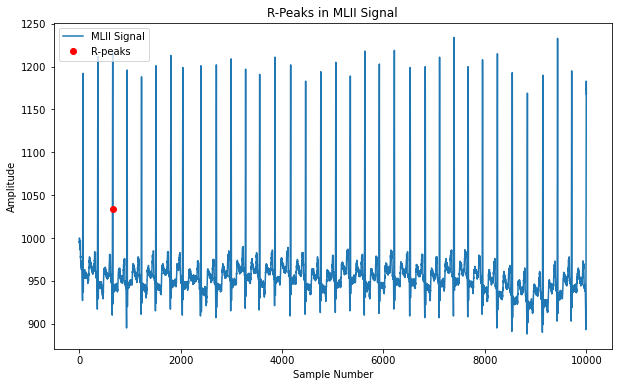

In [9]:
# Slicing the DataFrame to include only the first 500 samples
df_x = df.iloc[:10000]

# Filtering R-peaks to include only those within the first 500 samples
r_peaks_x = r_peaks2[r_peaks2 < 10000]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')
plt.plot(df_x['samp_num'][r_peaks_x], df_x['MLII'][r_peaks_x], 'ro', label='R-peaks')
plt.title('R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()